In [1]:
# function to calculate TEM diagnostics
# This assumes the data have already been organized into zonal mean fluxes
# Uzm, THzm, VTHzm, Vzm, UVzm, UWzm, Wzm as was done by ctem.F90 for FV dycore
# note that here we are calculating the E-P fluxes on model interface levels, which is ok
# in the stratosphere but not in the troposphere.  If interested in tropospheric
# E-P flux diagnostics, make sure they have been interpolated to pressure already.

# adapted from code by Isla Simpson Feb 25th 2021

In [2]:
import xarray as xr
import numpy as np
from scipy import integrate
from numpy import ma

In [3]:
import matplotlib.pyplot as plt

In [4]:
test_file = '/glade/scratch/fvitt/FWsc2000climo_f09_TEM_test05/run/FWsc2000climo_f09_TEM_test05.cam.h6.0001-01-01-00000.nc'
ds = xr.open_dataset(test_file)

In [84]:
def calc_tem(ds):

    # constants for TEM calculations
    p0 = 101325. 
    a = 6.371e6 
    om = 7.29212e-5
    H = 7000.
    g0 = 9.80665

    nlat = ds['lat'].size
    nlev = ds['ilev'].size

    latrad = np.radians(ds.lat)
    coslat = np.cos(latrad)
    coslat2d = np.tile(coslat,(nlev,1))
    
    pre = ds['ilev']*100. # pressure levels in Pascals
    f = 2.*om*np.sin(latrad[:])
    f2d = np.tile(f,(nlev,1))
    
    # change missing values to NaNs
    uzm = ds['Uzm']
    uzm.values = ma.masked_greater_equal(uzm, 1e33)
    vzm = ds['Vzm']
    vzm.values = ma.masked_greater_equal(vzm, 1e33)
    wzm = ds['Wzm']
    wzm.values = ma.masked_greater_equal(wzm, 1e33)
    thzm = ds['THzm']
    thzm.values = ma.masked_greater_equal(thzm, 1e33)

    uvzm = ds['UVzm']
    uvzm.values = ma.masked_greater_equal(uvzm, 1e33)
    uwzm = ds['UWzm']
    uwzm.values = ma.masked_greater_equal(uwzm, 1e33)
    vthzm = ds['VTHzm']
    vthzm.values = ma.masked_greater_equal(vthzm, 1e33)

    
    # convert w terms from m/s to Pa/s
    wzm  = -1.*wzm*pre/H
    uwzm = -1.*uwzm*pre/H

    # compute the latitudinal gradient of U
    dudphi = (1./a)*np.gradient(uzm*coslat2d, 
                                latrad, 
                                axis=1)
    
    # compute the vertical gradient of theta and u
    dthdp = np.gradient(thzm, 
                        pre, 
                        axis=0)
    
    dudp = np.gradient(uzm,
                       pre,
                       axis=0)

    # compute eddy streamfunction and its vertical gradient
    psieddy = vthzm/dthdp
    dpsidp = np.gradient(psieddy,
                         pre,
                         axis=0)

    # (1/acos(phii))**d(psi*cosphi/dphi) for getting w*
    dpsidy = (1./(a*coslat2d)) \
           * np.gradient(psieddy*coslat2d,
                         latrad, 
                         axis=1)

    # TEM vertical velocity (Eq A7 of dynvarmip)
    wtem = wzm+dpsidy    
    
    # utendwtem (Eq A10 of dynvarmip)
    utendwtem = -1.*wtem*dudp

    # vtem (Eq A6 of dynvarmip)
    vtem = vzm-dpsidp
    
    # utendvtem (Eq A9 of dynvarmip)
    utendvtem = vtem*(f2d - dudphi) 

    # calculate E-P fluxes
    epfy = a*coslat2d*(dudp*psieddy - uvzm) # A2
    epfz = a*coslat2d*((f2d-dudphi)*psieddy - uwzm) # A3

    # calculate E-P flux divergence and zonal wind tendency 
    # due to resolved waves (A5)
    depfydphi = (1./(a*coslat2d)) \
              * np.gradient(epfy*coslat2d,
                            latrad, 
                            axis=1)
        
    depfzdp = np.gradient(epfz,
                          pre,
                          axis=0)
    
    utendepfd = (1./(a*coslat2d))*(depfydphi + depfzdp)
    
    # TEM stream function, Eq (A8)
    topvzm = np.zeros([1,nlat])
    vzmwithzero = np.concatenate((topvzm, vzm), axis=0)
    prewithzero = np.concatenate((np.zeros([1]), pre))
    intv = integrate.cumtrapz(vzmwithzero,prewithzero,axis=0)
    psitem = (2*np.pi*a*coslat2d/g0)*(intv - psieddy)
   
    # final scaling of E-P fluxes and divergence to transform to log-pressure
    epfy = epfy*pre/p0      # A13
    epfz = -1.*(H/p0)*epfz  # A14
    wtem = -1.*(H/pre)*wtem # A16

    # add long name and unit attributes to TEM diagnostics
    epfy.attrs['long_name'] = 'northward component of E-P flux'
    epfy.attrs['units'] = 'm3/s2'
    
    epfz.attrs['long_name'] = 'upward component of E-P flux'
    epfz.attrs['units'] = 'm2/s2'

    vtem.attrs['long_name'] = 'Transformed Eulerian mean northward wind'
    vtem.attrs['units'] = 'm/s'
    
    wtem.attrs['long_name'] = 'Transformed Eulerian mean upward wind'
    wtem.attrs['units'] = 'm/s'
    
    psitem.attrs['long_name'] ='Transformed Eulerian mean mass stream function'
    psitem.attrs['units'] = 'kg/s'
    
    dstem = xr.Dataset(data_vars=dict(uzm = uzm,
                                      vzm = vzm, 
                                      epfy = epfy,
                                      epfz = epfz,
                                      vtem = vtem,
                                      wtem = wtem,
                                      psitem = psitem))

    return dstem


In [85]:
dstem = calc_tem(ds.squeeze().isel(time=-1))
dstem

<xarray.Dataset>
Dimensions:  (lat: 192, ilev: 71)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    zlon     float64 0.0
  * ilev     (ilev) float64 4.5e-06 7.42e-06 1.223e-05 ... 967.5 985.1 1e+03
    time     object 0001-03-01 00:00:00
Data variables:
    uzm      (ilev, lat) float32 0.0 -0.5974 -1.187 ... -0.8296 -0.4593 0.0
    vzm      (ilev, lat) float32 0.0 0.2134 0.4313 0.6284 ... -0.3601 -0.205 0.0
    epfy     (ilev, lat) float64 1.134e-33 -0.0005274 ... -1.382e+05 2.747e-25
    epfz     (ilev, lat) float64 -0.0 -1.883e-05 -4.24e-05 ... 3.019e+03 -0.0
    vtem     (ilev, lat) float32 0.0 0.2373 0.4745 ... -0.01081 0.05807 0.0
    wtem     (ilev, lat) float64 -6.918e+10 0.00499 ... -0.003988 -4.991e+11
    psitem   (ilev, lat) float64 0.0 3.107 12.33 ... 5.272e+08 2.65e+08 0.0

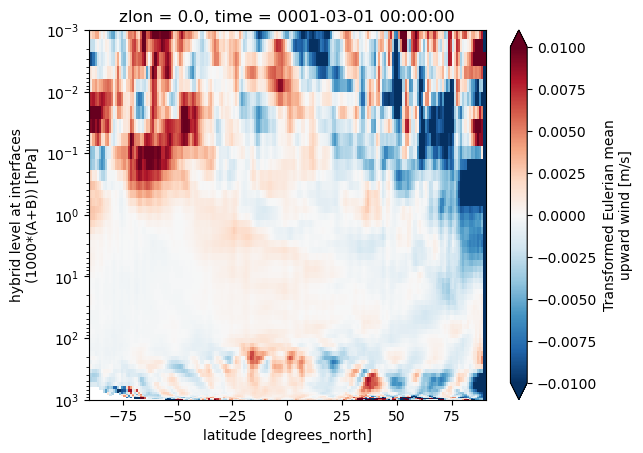

In [83]:
dstem.wtem.plot(y='ilev',yscale='log',ylim=[1e3,1e-3], vmax=.01 )
plt.show()

In [ ]:
    uzm = xr.DataArray(uzm, coords = tem_coords, name='uzm', 
                     attrs={'long_name':'zonal mean zonal wind', 'units':'m/s'})
    epfy = xr.DataArray(epfy, coords = tem_coords, name='epfy', 
                     attrs={'long_name':'northward component of E-P flux', 'units':'m3/s2'})
    epfz = xr.DataArray(epfz, coords = tem_coords, name='epfz', 
                     attrs={'long_name':'upward component of E-P flux', 'units':'m2/s2'})
    vtem = xr.DataArray(vtem, coords = tem_coords, name='vtem', 
                     attrs={'long_name':'Transformed Eulerian mean northward wind', 'units':'m/s'})
    wtem = xr.DataArray(wtem, coords = tem_coords, name='wtem', 
                     attrs={'long_name':'Transformed Eulerian mean upward wind','units':',/s'})
    psitem = xr.DataArray(psitem, coords = tem_coords, name='psitem',
                     attrs={'long_name':'Transformed Eulerian mean mass stream function','units':'kg/s'})
    utendepfd = xr.DataArray(utendepfd, coords = tem_coords, name='utendepfd',
                     attrs={'long_name':'tendency of eastward wind due to Eliassen-Palm flux divergence',
                           'units':'m/s2'})
    utendvtem = xr.DataArray(utendvtem, coords = tem_coords, name='utendvtem',
                    attrs={'long_name':'tendency of eastward wind due to TEM northward wind advection and the coriolis term',
                           'units':'m/s2'})
    utendwtem = xr.DataArray(utendwtem, coords = tem_coords, name='utendwtem',
                    attrs={'long_name':'tendency of eastward wind due to TEM upward wind advection',
                           'units':'m/s2'})

